# Apprentice Chef Report to Management

<b>Student</b>: Gustavo A. Trigos 

<b>Class Cohort</b>: MsBA3

<b>Class</b>: Machine Learning - DAT5303

## Executive Summary (Report to Management)

### Introduction

The Data team was tasked to utilize aggregated customer information to estimate both revenue over the first year of each customer’s life cycle and the type of customer that converts to the Halfway There cross-selling promotion. A set of regression and classification models were developed.

### Insights and Recommendations for Revenue

The model found that a percentage increase in the ratio between the number of times a customer attended a master class and the average meal preparation time in seconds [the ratio] decreases revenue by 2.50%. Moreover, a percentage increase in the number of master classes attended per customer increased revenue by 55 basis points. 

* The team recommends the company to increase the number of hosted master cooking classes from a quarterly frequency to a monthly frequency to increase customer attendance. 
* Because the ratio diminishes the prospects of estimated revenue, the team advises the company to produce longer and more advanced meal preparation videos. This change can increase the average time it takes customers to watch the videos, consequently increasing video retention.


### Insights and Recommendations for Cross-Sales Success

The top two characteristics to explain cross-sell promotion success according to the model are the email category of a customer. While there was no significant difference between the proportions of those customers with personal or professional emails that converted to the promotion, 92% of the costumes with junk email did not convert. 

* Assuming junk emails ignore marketing communication, it is recommended for the marketing team to create an online campaign with a custom email audience. This can increase the effectiveness in targeting new customers that would be more susceptible to register with non-junk emails and join promotions. 
* To avoid getting high cost per customer acquisition, the email audience can be generalized by removing certain domains from the junk category.


### Model Results

In [135]:
# Model Results
print("Revenue: Highest R-squared of 0.819 with Ordinary Least Square (OLS) Regression.")
print("Cross-Sales Success: Highest Area Under the Curve (AUC) score of 0.847 with Gradient Boosting Machine.")

Revenue: Highest R-squared of 0.819 with Ordinary Least Square (OLS) Regression.
Cross-Sales Success: Highest Area Under the Curve (AUC) score of 0.8473 with Gradient Boosting Machine.


# Appendix: Model Development Code

## Libraries

In [68]:
# Data exploration and manipulation essentials
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as rand

# Statistic tests
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor # Calculating VIF

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# Regression Models
from sklearn.linear_model import LinearRegression

# Classification Models
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

# Cross-validation
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer  

# Metrics
from sklearn.metrics import roc_auc_score, confusion_matrix

# Misc
import gender_guesser.detector as gender

In [69]:
# setting random seed
rand.seed(a = 219)

## Loading Data

In [70]:
# Loading the Apprentice Chef data set
df = pd.read_excel(io='./datasets/Apprentice_Chef_Dataset.xlsx')
dictionary = pd.read_excel(io='./datasets/Apprentice_Chef_Data_Dictionary.xlsx')

In [71]:
# Renaming column Largest order size to average meals ordered as indicated in the dictionary
df.rename(columns={'LARGEST_ORDER_SIZE': 'AVG_MEALS_ORDERED'}, inplace=True)

## Data Preprocessing

### Missing Values

In [72]:
# Dropping columns with missing values
df.drop(['FAMILY_NAME'],axis=1, inplace=True)

### Splitting Data into Numerical Data and Categorical

In [73]:
# Select all features excluding 'object' or categorical data
df_num = df.select_dtypes(exclude = 'object').copy()
df_cat = df.select_dtypes(include = 'object').copy()

In [74]:
# Excluding Revenue (Y-variable) from main analysis
response_var = 'CROSS_SELL_SUCCESS'
df_response = df_num[[response_var]]

# Dropping Response Variable
df_num.drop(response_var,axis=1,inplace=True)

### Exploring Cross Sales proportions

In [134]:
# Cross Sell Success proportion breakdown
# (df_response[response_var].value_counts() / df_response[response_var].shape[0]).round(decimals = 2)

## Numerical Data

### Outliers

In [76]:
# Z-score method: removing values with absolute Z-score greater than 3
z_score_condition = np.abs(stats.zscore(df_num)) < 3
df_num[z_score_condition.all(axis = 1)].shape

(1701, 23)

In [77]:
# Number of features where customer is an outlier
num_outliers = pd.DataFrame(z_score_condition).sum(axis=1)

### Binning Quantitative Data

In [78]:
# Revenue
df_num['revenue_class'] = pd.cut(
                           df_num['REVENUE'], 
                           bins=[131,1350,1740,2670,4000,8794], 
                           labels=["low_revenue", "mid_revenue", "mid_high_revenue","high_revenue","ultra_revenue"])

# Total Meal Orders (annual subscription)
df_num['annual_class'] = pd.cut(
                           df_num['TOTAL_MEALS_ORDERED'], 
                           bins=[11,155,259,493], 
                           labels=["no_annual_subscription", "basic_annual_subscription", "premium_annual_subscription"])


# Meal Rating
df_num['rating_class'] = pd.cut(
                           df_num['MEDIAN_MEAL_RATING'], 
                           bins=[0,2,4,5], 
                           labels=["sad_rating", "normal_rating", "happy_rating"])



In [79]:
# Dummy variable encoding
df_num = df_num.join(pd.get_dummies(df_num['revenue_class'], drop_first = True))
df_num = df_num.join(pd.get_dummies(df_num['annual_class'], drop_first = True))
df_num = df_num.join(pd.get_dummies(df_num['rating_class'], drop_first = True))

In [80]:
# Dropping original variables
df_num.drop(['revenue_class','annual_class','rating_class'], axis=1, inplace = True)

### Transformation

In [81]:
# Transform data to log transform
log_cols = ['TOTAL_MEALS_ORDERED',
'UNIQUE_MEALS_PURCH',
'CONTACTS_W_CUSTOMER_SERVICE',
'PRODUCT_CATEGORIES_VIEWED',
'AVG_TIME_PER_SITE_VISIT',
'CANCELLATIONS_BEFORE_NOON',
'WEEKLY_PLAN',
'EARLY_DELIVERIES',
'LATE_DELIVERIES',
'AVG_PREP_VID_TIME',
'AVG_MEALS_ORDERED',
'MEDIAN_MEAL_RATING',
'AVG_CLICKS_PER_VISIT',
'TOTAL_PHOTOS_VIEWED',
'REVENUE'] 

# Creating new columns with new log prefix and natural logarithm transformation.
for col in log_cols:
    # Adding constant 1 to avoid transforming log of zero
    df_num.loc[:,'log_'+col] = np.log(df_num[col]+1)

In [82]:
# Dropping original values after being transformed
df_num.drop(log_cols,axis=1,inplace=True)

In [83]:
# Adding extra columns with number of outlier detection
df_num['OUTLIERS_NUM'] = num_outliers

In [84]:
# Creating binary data to encompass those who have viewed photos vs. those who have not
df_num['SEEN_PHOTOS'] = (df_num['log_TOTAL_PHOTOS_VIEWED']==0).astype('int')

## Categorical Data

In [85]:
# Subsetting observations from numerical data 
df_cat = df_cat.loc[df_num.index]

### Names and Gender

In [86]:
# guessing gender based on (given) name

def gender_guesser():
    # placeholder list
    placeholder_lst = []

    # looping to guess gender
    for name in df_cat.loc[:,'FIRST_NAME']:
        guess = gender.Detector(case_sensitive=False).get_gender(name)
        print(guess)
        placeholder_lst.append(guess)
    
    return placeholder_lst

# converting list into a series
# placeholder_lst = gender_guesser()
#pd.Series(placeholder_lst).to_csv('name_gender_guesser.csv')

In [87]:
# Loading gender guess csv
gender_guess = pd.read_csv('./name_gender_guesser.csv')
df_cat['GENDER_GUESS'] = pd.Series(gender_guess['GENDER_GUESS'])

In [133]:
# Observing proportions for the first time
# (df_cat['GENDER_GUESS'].value_counts() / df_cat.shape[0]).round(2)

In [89]:
# Assigning classes
df_cat.loc[(df_cat['GENDER_GUESS'] == 'mostly_female') ,'GENDER_GUESS'] = 'female'
df_cat.loc[(df_cat['GENDER_GUESS'] == 'mostly_male') ,'GENDER_GUESS'] = 'male'

# int assignment
female = 1
male = 0

df_cat.loc[(df_cat['GENDER_GUESS'] == 'andy') ,'GENDER_GUESS'] = np.random.randint(2, size=df_cat.loc[(df_cat['GENDER_GUESS'] == 'andy') ,'GENDER_GUESS'].shape[0])
df_cat['GENDER_GUESS'].replace(female,'female', inplace=True)
df_cat['GENDER_GUESS'].replace(male,'male', inplace=True)

In [90]:
# Unknown Gender Imputation
unknown_condition = (df_cat['GENDER_GUESS'] == 'unknown') 

# Create dummy variable for unknown gender
df_cat['GENDER_UNKNOWN'] = unknown_condition.astype('int')

# All surnames that are unknown and end with 'a' are assigned female
a_condition = df_cat['FIRST_NAME'].str.endswith('a')
df_cat.loc[((unknown_condition & a_condition)),'GENDER_GUESS'] = 'female'
           
# All surnames that are unknown and end with 'o' are assigned to male 
o_condition = df_cat['FIRST_NAME'].str.endswith('o')
df_cat.loc[((unknown_condition & o_condition)),'GENDER_GUESS'] = 'male'         

In [91]:
# Adding random choice to all the variables that are unknown
df_cat.loc[unknown_condition ,'GENDER_GUESS'] = np.random.randint(2, size=df_cat.loc[unknown_condition ,'GENDER_GUESS'].shape[0])
df_cat['GENDER_GUESS'].replace(female,'female', inplace=True)
df_cat['GENDER_GUESS'].replace(male,'male', inplace=True)

In [92]:
# Changing to binary variable
df_cat['GENDER_GUESS'] = df_cat['GENDER_GUESS'].replace('female',female).replace('male',male)

In [93]:
# Filling remaining NA with male (given known proportions were skewed towards male)
df_cat['GENDER_GUESS'].fillna(female, inplace=True)

### Names and Length

In [94]:
# Finding number of names that a customer have
df_cat['NAME_NUM'] = (df_cat['NAME'].str.count(' ') + 1)

In [95]:
# funding number of characters (without spaces)
df_cat['NAME_CHAR'] = df_cat['NAME'].str.replace(' ', '').str.len()

### Email Classification

In [96]:
# Creating Email Domain column by spliting email from '@' character
df_cat['EMAIL_DOMAIN'] = '@' + df_cat['EMAIL'].str.split('@',expand=True)[1]

In [97]:
# Email classification process
professional_email = ['@mmm.com' 
            ,'@amex.com' 
            ,'@apple.com'
            ,'@boeing.com'
            ,'@caterpillar.com' 
            ,'@chevron.com' 
            ,'@cisco.com' 
            ,'@cocacola.com' 
            ,'@disney.com' 
            ,'@dupont.com' 
            ,'@exxon.com' 
            ,'@ge.org'
            ,'@goldmansacs.com'
            ,'@homedepot.com' 
            ,'@ibm.com' 
            ,'@intel.com' 
            ,'@jnj.com'
            ,'@jpmorgan.com'
            ,'@mcdonalds.com' 
            ,'@merck.com' 
            ,'@microsoft.com'
            ,'@nike.com' 
            ,'@pfizer.com' 
            ,'@pg.com' 
            ,'@travelers.com'
            ,'@unitedtech.com'
            ,'@unitedhealth.com' 
            ,'@verizon.com' 
            ,'@visa.com' 
            ,'@walmart.com']

personal_email = ['@gmail.com', '@yahoo.com', '@protonmail.com']

junk_email = ['@me.com', '@aol.com', '@hotmail.com', '@live.com', '@msn.com', '@passport.com']

In [98]:
# Professional Class
df_cat.loc[df_cat['EMAIL_DOMAIN'].isin(professional_email),'EMAIL_CLASS'] = 'professional'

# Personal Class
df_cat.loc[df_cat['EMAIL_DOMAIN'].isin(personal_email),'EMAIL_CLASS'] = 'personal'

# Junk Class
df_cat.loc[df_cat['EMAIL_DOMAIN'].isin(junk_email),'EMAIL_CLASS'] = 'junk'

In [132]:
# Email class proportions
# (df_cat['EMAIL_CLASS'].value_counts() / df_cat.shape[0]).round(2)

In [131]:
# Proportions of those that converted to cross-sell promotion grouped by email class
# (df_cat.join(df[response_var])[['EMAIL_CLASS','CROSS_SELL_SUCCESS']].groupby(['EMAIL_CLASS']).sum()/df_cat.shape[0]).round(4)

In [33]:
# Creating one-hot-encoding for Email Class column, deletes one class (K - 1)
df_cat = df_cat.join(pd.get_dummies(df_cat['EMAIL_CLASS'], drop_first = True))

In [34]:
# Cleaning columns that are irrelevant
df_cat.drop(['NAME','EMAIL','FIRST_NAME','EMAIL_DOMAIN','EMAIL_CLASS'],axis=1, inplace=True)

## Feature Engineering

In [35]:
# Joining number data with categorical data, then separating features from the target value.
df_features = df_cat.join(df_num)

### Domain Knowledge Features

In [36]:
## Average Number of Unique Meals per order 
df_features['MEALS_PER_ORDER'] = df_features['log_TOTAL_MEALS_ORDERED'] / df_features['log_UNIQUE_MEALS_PURCH']

# TOTAL_PHOTOS_VIEWED per total logins
df_features['PHOTOS_VIEWED_LOGIN'] = df_features['log_TOTAL_PHOTOS_VIEWED'] / (df_features['MOBILE_LOGINS'] + df_features['PC_LOGINS'])

# LATE_DELIVERIES  per CONTACTS_W_CUSTOMER_SERVICE
df_features['LATE_DELIVERIES_CUSTOMER'] = df_features['log_LATE_DELIVERIES'] / df_features['log_CONTACTS_W_CUSTOMER_SERVICE']

# MEDIAN_MEAL_RATING per AVG_PREP_VID_TIME
df_features['RATING_VID_TIME'] = df_features['log_MEDIAN_MEAL_RATING'] / df_features['log_AVG_PREP_VID_TIME']

# AVG_MEALS_ORDERED per AVG_TIME_PER_SITE_VISIT
df_features['ORDERS_PER_VISIT'] = df_features['log_AVG_MEALS_ORDERED'] / df_features['log_AVG_TIME_PER_SITE_VISIT']

# MEDIAN_MEAL_RATING per EARLY_DELIVERIES 
df_features['RATING_EARLY_DELIVERIES'] = df_features['log_MEDIAN_MEAL_RATING'] / df_features['log_EARLY_DELIVERIES']

# MASTER_CLASSES_ATTENDED per AVG_PREP_VID_TIME
df_features['CLASS_PER_VID_TIME'] = df_features['MASTER_CLASSES_ATTENDED'] / df_features['log_AVG_PREP_VID_TIME']


In [37]:
# Making sure inf values turn into nan
df_features.replace([np.inf, -np.inf], np.nan,inplace=True)
df_features.fillna(0,inplace=True)

### Interactions

In [38]:
# Create every possible bivariate combination to be tested for feature engineering
from itertools import combinations

interaction_list = ['log_REVENUE',
'log_TOTAL_MEALS_ORDERED',
'log_UNIQUE_MEALS_PURCH',
'log_CONTACTS_W_CUSTOMER_SERVICE',
'log_PRODUCT_CATEGORIES_VIEWED',
'log_AVG_TIME_PER_SITE_VISIT',
'log_CANCELLATIONS_BEFORE_NOON',
'log_WEEKLY_PLAN',
'log_EARLY_DELIVERIES',
'log_LATE_DELIVERIES',
'log_AVG_PREP_VID_TIME',
'log_AVG_MEALS_ORDERED',
'log_MEDIAN_MEAL_RATING',
'log_AVG_CLICKS_PER_VISIT',
'log_TOTAL_PHOTOS_VIEWED']

interactions = list(combinations(interaction_list, 2))

In [39]:
# Iterate through interaction list to perform linear regression for each possible engineered features
for interaction in interactions:
    df_features['{}_{}'.format(interaction[0],interaction[1])] = df_features[interaction[0]] * df_features[interaction[1]]

df_features.shape

(1946, 151)

## Train-Test Split

In [40]:
# Dividing dataset into dependent and independent variables (Revenue Regression)
X_reg = df_features[df_features.columns.drop(list(df_features.filter(regex='REVENUE')))].join(df[response_var])
X_reg.drop(list(df_features.filter(regex='revenue')),axis=1,inplace=True)
y_reg = np.log(df['REVENUE']+1)

In [41]:
# Dividing dataset into dependent and independent variables (Cross Sale Success Classification)
X_class = df_features
y_class = df_response[response_var]

### Split

In [42]:
# Splitting the dataset into 75% Trainning and 25% Testing sets for regression model
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, 
                                                                    test_size = 0.25, 
                                                                    random_state = 219)

In [43]:
# Splitting the dataset into 75% Trainning and 25% Testing sets for classification model
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, 
                                                                            test_size = 0.25, 
                                                                            random_state = 219, 
                                                                            stratify=y_class)

## Predictive Model Development

In [44]:
# Defining a function to output regression metrics

def regression_metrics(model,X_train,y_train,X_test,y_test):
    
    # FITTING the training data
    model_fit = model.fit(X_train,y_train)


    # PREDICTING on new data
    model_pred = model_fit.predict(X_test)

    # saving scoring data for future use
    model_train_score = model.score(X_train,y_train).round(decimals = 4)
    model_test_score  = model.score(X_test,y_test).round(decimals = 4)
    model_test_gap = abs(model_train_score - model_test_score).round(decimals = 4)
    
    # Saving coefficients in list
    
    try:
        # Zipping each feature name to coefficient
        model_values = zip(X_train.columns, model_fit.coef_.round(decimals = 7))

        # setting up a placeholder list to store model features
        model_lst = [('intercept', model_fit.intercept_.round(decimals = 7))]

        # Appending coefficients to model list
        for val in model_values:
            if (val[1] != 0):
                model_lst.append(val)
    
    except:
        model_lst = []
    
    return model_train_score, model_test_score, model_test_gap, model_lst
    

In [45]:
# Defining a function to output classification metrics

def classification_metrics(model,X,y,X_train,y_train,X_test,y_test):
    
    # FITTING on the whole data (tuned models went through Cross-Validation with the whole data)
    model_fit = model.fit(X,y)
    
    # PREDICTING on new data
    model_pred = model_fit.predict(X_test)

    # saving scoring data for future use
    model_train_score = model.score(X_train,y_train).round(decimals = 4)
    model_test_score  = model.score(X_test,y_test).round(decimals = 4)
    
    # ROC-AUC score  (test score)
    auc_score = roc_auc_score(y_test,model_pred).round(decimals = 4)
    
    # unpacking the confusion matrix
    model_tn, model_fp, model_fn, model_tp = confusion_matrix(y_true = y_test, y_pred = model_pred).ravel()
    
    # Confusion Matrix
    c_matrix = (model_tn, model_fp, model_fn, model_tp)
    
    return model_train_score, model_test_score, auc_score, c_matrix
    

In [59]:
# Defining a function to visualize CART models feature importance
def plot_feature_importances(model, X_train, top_features=10):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    top_features : number of top features to show
    
    """
    
    # Getting features and their relative importance according to the model
    features = X_train.columns
    feature_importance = model.feature_importances_

    # Creating dataframe 
    feature_importance_df = pd.DataFrame(data={'Feature Importance': feature_importance},index=features)
    
    # Sorted and top features
    sorted_df = feature_importance_df.sort_values(by='Feature Importance', ascending=False).head(top_features)

    # Plotting the result
    sorted_df.plot.barh()
    plt.title("Gradient Boosting Model Relative Feature Importance")
    plt.xlabel("Feature importance (%)")
    

### Multiple Linear Regression (OLS)

In [47]:
# Instantiating OLS Linear Regression model
linear_regression = LinearRegression()

### Gradient Boosted Classification Model (GBM)

In [48]:
# Instantiating GBM
gradient_boosting = GradientBoostingClassifier(max_depth=8)

In [49]:
# # Hyperparameter tuning 

# # declaring a hyperparameter space
# n_estimators_space          = np.arange(50, 200, 20)
# max_depth_space  = np.arange(3, 8, 1)
# max_leaf_nodes_space = np.arange(10, 30, 2)


# # creating a hyperparameter grid
# param_grid = {
#                 'n_estimators'          : n_estimators_space ,
#                 'max_depth'     : max_depth_space,
#              'max_leaf_nodes'     : max_leaf_nodes_space}


# # INSTANTIATING the model object without hyperparameters
# boost_tuned = gradient_boosting



# # RandomizedSearchCV object
# boost_tuned_cv = RandomizedSearchCV(estimator           = boost_tuned,   # the model object
#                                  param_distributions = param_grid, # parameters to tune
#                                  cv                  = 3,          # how many folds in cross-validation
#                                  n_iter              = 1000,        # number of combinations of hyperparameters to try
#                                  random_state        = 219,        # starting point for random sequence
#                                  scoring = make_scorer(
#                                            roc_auc_score,
#                                            needs_threshold = False)) # scoring criteria (AUC)




# # FITTING to the FULL DATASET (due to cross-validation)
# boost_tuned_cv.fit(X, y)


# # printing the optimal parameters and best score
# print("Tuned Parameters  :", boost_tuned_cv.best_params_)
# print("Tuned CV AUC      :", boost_tuned_cv.best_score_.round(4))


In [50]:
# Storing tuned parameters in dictionary
boost_params = {'n_estimators': 70, 'max_leaf_nodes': 12, 'max_depth': 4}

# Setting tuned parameters
gradient_boosting = gradient_boosting.set_params(**boost_params)

## Model Regression Performance (Estimating Customer Revenue)

In [51]:
linear_train_score, linear_test_score, linear_test_gap, linear_model_lst = regression_metrics(linear_regression,X_train_reg,y_train_reg,X_test_reg,y_test_reg)

In [52]:
# creating a dictionary to store model results
regression_model_performance = {
    
    'Model Type'    : ['OLS (Final Model)'],
           
    'Training Score' : [linear_train_score],
           
    'Testing Score'  : [linear_test_score],
                    
    'Train-Test Gap' : [linear_test_gap],
                    
    'Model Size' : [len(linear_model_lst)],
                    
    'Model Coefficients' : [linear_model_lst]}


# converting model_performance into a DataFrame
regression_model_performance = pd.DataFrame(regression_model_performance)
regression_model_performance

,Model Type,Training Score,Testing Score,Train-Test Gap,Model Size,Model Coefficients
0,OLS (Final Model),0.8378,0.8199,0.0179,134,"[(intercept, 13.4050092), (GENDER_GUESS, 0.010..."


### Regression Coefficient and Statistics

In [53]:
# Instantiating Statsmodel OLS Linear Regression model
variables = "+".join(X_train_reg.columns)
formula = 'REVENUE ~ ' + variables

stats_regression = smf.ols(formula = formula,data = X_train_reg.join(y_train_reg))

# telling Python to FIT the data to the blueprint
results = stats_regression.fit()

regression_output = pd.DataFrame(index=results.params.index)
regression_output['Coefficients'] = results.params
regression_output['Significance'] = results.pvalues

In [137]:
# Top 5 strongest positive coefficients (log-log format)
regression_output.sort_values(by='Coefficients',ascending=False).iloc[1:6].round(3)

,Coefficients,Significance
log_AVG_MEALS_ORDERED,2.551,0.084
log_AVG_TIME_PER_SITE_VISIT,0.975,0.080
log_LATE_DELIVERIES,0.746,0.116
MASTER_CLASSES_ATTENDED,0.549,0.004
log_MEDIAN_MEAL_RATING,0.475,0.920


In [136]:
# Top 5 strongest negative coefficients (log-log format)
regression_output.sort_values(by='Coefficients',ascending=True).iloc[:5].round(3)

,Coefficients,Significance
log_CONTACTS_W_CUSTOMER_SERVICE,-3.782,0.000
CLASS_PER_VID_TIME,-2.490,0.010
log_TOTAL_MEALS_ORDERED,-2.206,0.000
RATING_VID_TIME,-1.374,0.901
ORDERS_PER_VISIT,-1.301,0.076


## Model Classification Performance (Classifying Cross Sales Success)

In [56]:
# Running function gather score of models
gradient_train_score, gradient_test_score, gradient_auc_score, gradient_c_matrix  = classification_metrics(gradient_boosting,X_class,y_class,X_train_class,y_train_class,X_test_class,y_test_class)

In [57]:
# creating a dictionary to store model results
classification_model_performance = {
    
    'Model Type'    : ['GBM (Final Model)'],
           
    
    'AUC Score'  : [gradient_auc_score],
    
    'Training Accuracy' : [gradient_train_score],
           
    'Testing Accuracy'  : [gradient_test_score],
    
    'Confusion Matrix' : [gradient_c_matrix]

}


# converting model_performance into a DataFrame
classification_model_performance = pd.DataFrame(classification_model_performance)
classification_model_performance

,Model Type,AUC Score,Training Accuracy,Testing Accuracy,Confusion Matrix
0,GBM (Final Model),0.8393,0.867,0.883,"(112, 44, 13, 318)"


 
            According to the model, the number of names that a customer has is the most important feature, 
            followed by whether if the customer has a personal or professional email.



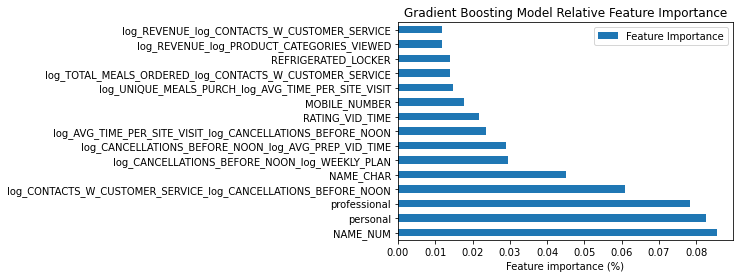

In [139]:
# Plotting relative feature importance sa
plot_feature_importances(gradient_boosting, X_train_class, 15)
print(""" 
            According to the model, the number of names that a customer has is the most important feature, 
            followed by whether if the customer has a personal or professional email.
""")